# 使用无监督算法进行税务欺诈检测 

- 数据集名称：财产估价和评估数据
- 数据集描述：纽约市房地产评估财产数据。数据代表纽约市房产评估，用于计算房产税、授予符合条件的房产豁免和/或减税。
- 数据集来源：纽约市开放数据
- 数据集时间段：11/17/2010
- 字段数：32
- 数据量：1,070,994


数据代表纽约市的房产价值评估，目的是计算房产税、授予符合条件的房产豁免或减税。纽约市部分房产数据与实际严重不符，会导致房产税等级错误。此类错误的住房信息可能会导致欺诈或欺骗活动以获取非法利益。

项目通过构建无监督的欺诈检测模型来识别和预测纽约市财产的财产税欺诈。主要目的是识别可疑记录，并转交相关部门进一步调查。

#### 分析步骤
1. 数据清洗，填写缺失字段
2. 变量创建——构建专家变量来量化各种欺诈信号；从现有数据中提取模式以精确估计财产价值
3. 降维——使用 PCA 去除相关性并降低数据维度；在 PCA 之前和之后进行 z scale。
4. 欺诈模型算法——描述得分 1 和 2 的算法，以及最终分数。
5. 结果分析——分析前面步骤中的结果并手动调查部分可能的欺诈记录

#### 欺诈分值
- 分数 1 是作为 z-scaled PCs 的欺诈分数。使用与原点的欧几里得距离作为对极端程度的描述。
- 分数 2 基于自动编码器训练的数据。该分数是原始输入记录和自动编码器输出记录的平方差的度量。
- 最终得分：前两者的加权平均值，权重各为 50%。

根据最终的欺诈分数对所有记录进行排名。最终得分高的案件代表潜在的财产税欺诈。

选取5个得分最高的可疑记录进一步调查。它们的共同特点是建筑物的尺寸和楼层不准确。

### 数据说明

| | COLUMN NAME | 字段名称 | 说明 |
|---:|---------:|---|---|
|  1 |   RECORD |   | File key, to uniquely identify each record in the dataset.  |
|  2 |     BBLE |   | Concatenation of BORO code and Block ranges.  |
|  3 |        B | 市 | BORO code. 1 = Manhattan, 2= Bronx, 3= Brooklyn, 4 = Queens, 5 = Staten Island.  |
|  4 |    BLOCK | 街区 | Valid block ranges by BORO. Manhattan 1 to 2255, Bronx 2260 to 5958, Brooklyn 1 to 8955, Queens 1 to 16350, Staten Island 1 to 8050.  |
|  5 |      LOT | 地段 | Unique number within BORO/Block.  |
|  6 | EASEMENT | 地役权 | A field that is used to describe easement.  |
|  7 |    OWNER |   | Owner’s Name |
|  8 |   BLDGCL | 建筑种类  | Building Class. [NYC Building Classes & Building Classification](https://www.propertyshark.com/mason/text/nyc_building_class.html) |
|  9 | TAXCLASS |   | Current Property Tax Class Code (NYS Classification). <br> <br> TAX CLASS 1 = 1-3 UNIT RESIDENCES. <br> TAX CLASS 1A = 1-3 STORY CONDOMINIUMS. <br> TAX CLASS 1B = RESIDENTIAL VACANT LAND. <br> TAX CLASS 1C = 1-3 UNIT CONDOMINUMS. <br>  TAX CLASS 1D = SELECT BUNGALOW COLONIES. <br>  TAX CLASS 2 = APARTMENTS. <br>  TAX CLASS 2A = APARTMENTS WITH 4-6 UNITS.  <br>  TAX CLASS 2B = APARTMENTS WITH 7-10 UNITS.  <br>  TAX CLASS 2C = COOPS/CONDOS WITH 2-10 UNITS. <br>  TAX CLASS 3 = UTILITIES (EXCEPT CEILING RR). <br>  TAX CLASS 4A = UTILITIES - CEILING RAILROADS. <br>  TAX CLASS 4 = ALL OTHERS. |
| 10 |  LTFRONT |   | Lot frontage in feet.  |
| 11 |  LTDEPTH |   |Lot depth in feet|
| 12 |      EXT |   | Extension. 'E' = EXTENSION, 'G' = GARAGE, 'EG' = EXTENSION AND GARAGE.  |
| 13 |  STORIES |   | The number of stories for the building ( # of Floors).  |
| 14 |  FULLVAL |   | If not zero, Current year’s total market value of the land.  |
| 15 |   AVLAND |   | Total Land Area.  |
| 16 |    AVTOT |   |  Assessed total value. |
| 17 |   EXLAND |   | Exempt land value.  |
| 18 |    EXTOT |   | Exempt total value.  |
| 19 |    EXCD1 |   | Exempt condo.  |
| 20 |   STADDR |   | Street name for the property.  |
| 21 |      ZIP |   | Postal Zip code of the property.  |
| 22 |  EXMPTCL |   | Exempt Class used for fully exempt properties only.   |
| 23 | BLDFRONT |   | Building frontage in feet.  |
| 24 | BLDDEPTH |   | Lot depth in feet.  |
| 25 |  AVLAND2 |   | New market value of land.  |
| 26 |   AVTOT2 |   | New total market value.  |
| 27 |  EXLAND2 |   | New exempt land value.  |
| 28 |   EXTOT2 |   | New exempt total value.  |
| 29 |    EXCD2 |   | New exempt condo.  |
| 30 |   PERIOD |   | Indicator for the change period of the file. All records have same field value. |
| 31 |     YEAR |   | Year and month when the data was last updated. All records have same field value.  |
| 32 |  VALTYPE |   | The parcel’s values are reflected in another lot. All records have same field value.  |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

data = pd.read_csv('data/NY property data.csv')
data.shape

(1070994, 32)

## 数据处理

1. 移除部分缺失记录
2. 填补缺失字段
 - 填充 "ZIP"（邮编）字段
 - 填充“FULLVAL”（市场价值）、“AVLAND”（评估土地价值）和“AVTOT”（评估总价值）字段
 - 填补 “STORIES”（建筑物的层数）字段
 - 填补缺失的地块及建筑面积字段

### 移除部分缺失记录
- 对于寻找潜在的财产税欺诈来说，城市、州或联邦政府拥有的财产可以提前排除。
- 删除以下 OWNERS 的 24,168 条记录。

In [2]:
gov_owner = [
'PARKCHESTER PRESERVAT',
'PARKS AND RECREATION',
'DCAS',
'HOUSING PRESERVATION',
'CITY OF NEW YORK',
'DEPT OF ENVIRONMENTAL',
'BOARD OF EDUCATION',
'NEW YORK CITY HOUSING',
'CNY/NYCTA',
'NYC HOUSING PARTNERSH',
'DEPARTMENT OF BUSINES',
'DEPT OF TRANSPORTATIO',
'MTA/LIRR',
'PARCKHESTER PRESERVAT',
'MH RESIDENTIAL 1, LLC',
'LINCOLN PLAZA ASSOCIA',
'UNITED STATES OF AMER',
'U S GOVERNMENT OWNRD',
'THE CITY OF NEW YORK',
'NYS URBAN DEVELOPMENT',
'NYS DEPT OF ENVIRONME',
'CULTURAL AFFAIRS',
'DEPT OF GENERAL SERVI',
'DEPT RE-CITY OF NY']

for owner in gov_owner:
    data = data[data.OWNER != owner]
data.shape

(1046826, 32)

### 填补缺失字段

- “缺失”可能是重要的特征，但本项目中不会使用该特征。
- 我们应该删除缺少字段的记录吗？ – 不是一个好方法……
- 填充值应尽可能正常，不至于触发异常检测。因此使用该记录的该字段的最典型值来填充缺失的字段。

常用方法：

1. 建立模型来预测给定其他字段值的缺失值（太复杂）
2. 全部填充该字段的平均值，中位数或众数
3. 在相关记录子集上使用该字段的平均值，中位数或众数

这里将使用 `TAXCLASS` 作为几个字段插补的分组。

#### 填充 `ZIP`（邮编）字段

观察数据可知，记录大部分按zip排序。

所以按照如下规则填充缺失的 `ZIP` 数据：
1. 如果缺失的 record 的前一行和后一行相同，则替换为该邮政编码。
2. 对剩余的缺失值，用**前一行**的值填充。 通过查看街道地址（STADDR），我可以做得更好，但是我没有。

In [3]:
# 共有 21,772条记录缺少邮政编码（ZIP）。
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

21772

In [4]:
# 1. 如果缺失的 record 的前一行和后一行相同，则替换为该邮政编码。
for i in range(len(missing_zips)):
    if(data.iloc[missing_zips[i]+1,20] == data.iloc[missing_zips[i]-1,20]):
        data.iloc[missing_zips[i],20] = data.iloc[missing_zips[i]-1,20]
        
# 仍有 10245 条缺失数据。
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

In [7]:
# 2. 剩余的缺失值，用前一行的值填充。
for i in range(len(missing_zips) ):
    data.iloc[missing_zips[i],20] = data.iloc[missing_zips[i]-1,20]
    
# 完成填充该字段。
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

0

#### 填充`FULLVAL`（市场价值）、`AVLAND`（评估土地价值）和`AVTOT`（评估总价值）字段
1. 用 0 替换所有 `NaN`
2. 将这三个字段中非零值的存储在临时变量中
2. group by `TAXCLASS`（税种）字段，并求平均值
3. 用该均值替换缺失值

In [8]:
data['FULLVAL'].replace('NaN',0)
temp = data[data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64


In [9]:
data['AVLAND'].replace('NaN',0)
temp_avland = data[data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [10]:
data['AVTOT'].replace('NaN',0)
temp_avtot = data[data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

In [11]:
%%time

for index in mean_fullval.index:
    data.loc[(data['FULLVAL']==0)&(data['TAXCLASS']==index), 'FULLVAL']=mean_fullval[index]
    data.loc[(data['AVLAND']==0)&(data['TAXCLASS']==index), 'AVLAND']=mean_avland[index]
    data.loc[(data['AVTOT']==0)&(data['TAXCLASS']==index), 'AVTOT']=mean_avtot[index]

CPU times: user 3.93 s, sys: 40.6 ms, total: 3.98 s
Wall time: 3.83 s


#### 填补`STORIES`（建筑物的层数）字段

- 该字段缺少 43,968 条记录，约占记录的5％.并且这些记录中没有一条为该字段的值为 0。
- “STORIES”并不总是整数。 一栋建筑物可能高1.5层，这意味着该建筑物的一部分是一层，一部分是两层。

1. 首先按 `TAXCLASS`（税种）字段对数据进行分组，并计算“STORIES”（建筑物的层数）字段的均值。
2. 其次，将`STORIES`（建筑物的层数）字段下的所有缺失值替换为 0。
3. 然后，将`STORIES`（建筑物的层数）列中的所有 0 替换为相关的均值。


In [12]:
temp = data[data['STORIES'].isnull()]
len(temp)

43968

In [16]:
temp['TAXCLASS'].value_counts()

1B    19055
4     17979
2      3434
3      2416
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [17]:
mean_stories = data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111633
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.744977
3      1.000000
4      5.517257
Name: STORIES, dtype: float64


In [18]:
# 缺失值改成0，并用均值填充
data['STORIES']=data['STORIES'].fillna(value=0)
for index in mean_stories.index:
    data.loc[(data['STORIES']==0)&(data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [19]:
len(data[data['STORIES']==0])

0

In [20]:
data.head().transpose()

,0,1,8,9,10
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
B,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


#### 填补缺失的地块及建筑面积字段
- 大约有 200,000 条记录缺少部分或全部地块和建筑物大小。

1. 首先用'nan'替换了lot front, depth 和building front, depth 下的记录，它们的值为0和1。
2. 其次，我们在按税种对数据进行分组后计算了地块前沿、地块深度、建筑物前沿和建筑物深度字段的平均值。
3. 然后，我们用相关的平均值替换了“nan”下的记录。

In [24]:
# as these 4 values do not have NAs, we need to replace 0s. 
# calculate groupwise average. First replace the 0’s and 1’s by NAs so they are not counted in calculating mean.

data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# calculate the mean (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=data.groupby(data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=data.groupby(data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=data.groupby(data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=data.groupby(data['TAXCLASS'])['BLDDEPTH'].mean()

# impute values
for index in mean_LTFRONT.index:
    data.loc[(data['LTFRONT'].isnull())&(data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    data.loc[(data['LTDEPTH'].isnull())&(data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    data.loc[(data['BLDFRONT'].isnull())&(data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    data.loc[(data['BLDDEPTH'].isnull())&(data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

### Feature Engineering

In [25]:
# Variable Creation

data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]


data['ltsize'] = data['LTFRONT'] * data['LTDEPTH'] # 地块面积
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH'] # 建筑面积
data['bldvol'] = data['bldsize'] * data['STORIES'] # 建筑容积

# 用不同 ¥ 字段除以面积/容积，计算单位面积、单位容积的价值
data['r1'] = data['FULLVAL'] / data['ltsize'] 
data['r2'] = data['FULLVAL'] / data['bldsize'] 
data['r3'] = data['FULLVAL'] / data['bldvol'] 
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [26]:
ninevars = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']

zip5_mean = data.groupby('ZIP')[ninevars].mean()
zip3_mean = data.groupby('zip3')[ninevars].mean()
taxclass_mean = data.groupby('TAXCLASS')[ninevars].mean()
borough_mean = data.groupby('B')[ninevars].mean()

data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(zip3_mean, on='zip3', rsuffix='_zip3')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass' )
data = data.join(borough_mean, on='B', rsuffix='_boro')

rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']

for var in ninevars:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [30]:
data_copy = data.copy()
data = data[['r1','r2','r3','r4','r5','r6','r7','r8','r9',
'r1_zip5','r2_zip5','r3_zip5','r4_zip5','r5_zip5','r6_zip5','r7_zip5','r8_zip5','r9_zip5', 
'r1_zip3','r2_zip3','r3_zip3','r4_zip3','r5_zip3','r6_zip3','r7_zip3','r8_zip3','r9_zip3',
'r1_taxclass','r2_taxclass','r3_taxclass','r4_taxclass','r5_taxclass','r6_taxclass','r7_taxclass','r8_taxclass','r9_taxclass', 
'r1_boro','r2_boro','r3_boro','r4_boro','r5_boro','r6_boro','r7_boro','r8_boro','r9_boro']]
data.shape

(1046826, 45)

### Prepare Variables for model, PCA

In [31]:
# Z scale the variables before PCA
data = (data - data.mean()) / data.std()

(0.0, 1.0)

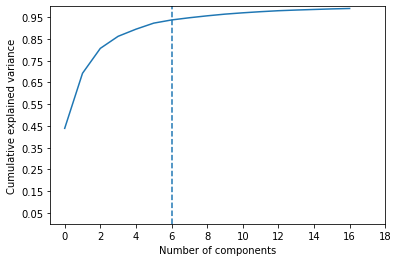

In [32]:
# Compute most of the PC components and look at the scree plot.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [33]:
# Keep the top 6 PCs. Recompute them.

pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046826, 6)

In [35]:
# Z scale the PC’s

pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,1.799526e-16,-1.036275e-15,1.363084e-16,-2.831104e-15,3.976334e-15,-4.788239e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585169e-01,-2.280285e+02,-1.990058e+02,-2.023902e+02,-2.438863e+02,-2.002482e+02
25%,-1.088008e-01,-1.544611e-01,-1.356178e-01,-3.269413e-02,-1.159056e-01,-1.101850e-01
50%,-2.375699e-02,-5.919442e-02,6.964975e-04,1.366905e-02,-1.313827e-02,-2.535381e-02
75%,3.290240e-02,3.225958e-02,3.206016e-01,7.018402e-02,4.879425e-02,1.382281e-01
max,6.907817e+02,3.239819e+02,5.967327e+02,2.507935e+02,4.068852e+02,4.017177e+02


In [36]:
# Now the data is ready for the fraud algorithms.

### Model 1: z score outliers



In [37]:
p=2
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p

### Model 2: autoencoder error

In [38]:
from keras.models import Model
from keras.layers import Input, Dense

# placeholder for input
data_in = Input(shape=(6,))

# dimension of the encoded data. Choose 3
encoded_dim = 3

# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)

# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)

# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(data_pca,data_pca, epochs=3, shuffle=True, validation_data=(data_pca,data_pca))

pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop

Epoch 1/3
32714/32714 [==============================] - 65s 2ms/step - loss: 0.8333 - val_loss: 0.8964
Epoch 2/3
32714/32714 [==============================] - 68s 2ms/step - loss: 0.9531 - val_loss: 0.8948
Epoch 3/3
32714/32714 [==============================] - 68s 2ms/step - loss: 0.8073 - val_loss: 0.8948


In [40]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
top_records = scores.sort_values(['final'],ascending=False).head(100).index

top_records

Int64Index([ 898846,  667828, 1042136, 1036415,  148125,   39267,   11988,
             115122,   33294,  648382,  241789,  914593,  317882,  105181,
              33107,   47704,  753749,  735155,  137449,  594392,   94946,
              55582,  232192,  317883,  102923,  648381,  622448,   14878,
             633027,  953143,  105223,  799571,   59907,  803133,  152679,
             799624,  893638,  206300,  107556,     413,  383734,     407,
              85924,   55581,   41418,   47468,    7030,  667687,  970553,
             898849,  973761,  973757,  973755,  973759,   88314,  694913,
             627152,   22981,    7032,  973763,   63702,  565123,  971098,
             898848,  984763,   56413,  115121,   87359,   29934,   73443,
             800347,  499768,  668040,  906638,  587330,  914592,   43737,
              84943,       1,  563493,   88313,  297298,  236160,   89163,
            1039216,    3822,  242437,  314946,  876550,  111951,  954279,
             954296,  954

In [71]:
df1 = data_copy.iloc[top_records,:]
df2 = scores.iloc[top_records,:]
result = pd.concat([df1.reset_index(),df2.reset_index()],axis=1).drop('index',axis=1)
result

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro,score1,score2,score1 rank,score2 rank,final
0,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910.0,...,15466.539425,9483.223161,578.658461,21241.269929,13819.328886,981.327286,981.059253,1046826.0,1046826.0,1046826.0
1,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2.0,...,0.130014,0.059788,173.992051,0.068600,0.033473,457.056987,455.328234,1046825.0,1046825.0,1046825.0
2,1065870,5076440001,5,7644,1,NaN,PEOPLE OF THE ST OF N,V0,1B,2891.0,...,288.581804,132.026423,0.188222,168.033421,76.374139,448.085038,446.612950,1046824.0,1046824.0,1046824.0
3,1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5.0,...,4.495532,1.491110,2407.601308,7.613169,2.508724,407.134435,405.388969,1046823.0,1046823.0,1046823.0
4,151044,2024930001,2,2493,1,NaN,NaN,Q6,4,798.0,...,830.518393,242.061023,93.912685,3520.689104,1197.063590,396.025262,393.943887,1046822.0,1046822.0,1046822.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,975066,5014911019E,5,1491,1019,E,JARRETT DEVELOP CO,Z7,4,10.0,...,4.495532,1.491110,601.900327,7.613169,2.508724,77.118785,75.450210,1046733.0,1046733.0,1046733.0
96,975055,5014911009E,5,1491,1009,E,NaN,Z7,4,10.0,...,4.495532,1.491110,601.900327,7.613169,2.508724,77.118785,75.450210,1046733.0,1046733.0,1046733.0
97,54899,1009440001,1,944,1,NaN,"301 HOLDINGS, LLC C/O",D6,2,98.0,...,95.841762,27.236001,9.148103,125.067615,45.937845,76.218210,74.838244,1046728.0,1046729.0,1046728.5
98,565397,3085910075,3,8591,75,NaN,U S GOVT NAVY,Y4,4,441.0,...,1656.275126,622.519782,38.853552,797.564750,329.853444,76.490804,74.740391,1046729.0,1046728.0,1046728.5


## 手动检查一些记录

**记录#1：917942**
- 此记录的地址是皇后区布鲁克维尔大道 154-68 号。该物业归 Logan Property, INC. 所有，在数据集中具有最高的欺诈分数。地块正面为 4910 英尺，地块深度为 0 英尺，而建筑正面和建筑深度均为 0 英尺。该物业的总估值超过3.74亿美元。真实的建筑维度缺失，地块维度没有意义，建筑是7层而不是3层，使得这个记录异常。

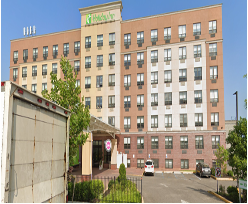

**记录#2：684704**
- 此记录的地址是 69 Street，并且缺少邮政编码。该物业归 W Rufert 所有，在数据集中具有第二高的欺诈分数。地块正面和地块深度均为 2 英尺，而建筑物正面和建筑物深度均为 0 英尺。房产全估为0，平均土地面积也为0。由于地址信息不完整，地块尺寸字段异常小，重要建筑尺寸字段和楼层字段全为0，使得该记录异常与其他人相比。

**记录#3：1065870**
- 此记录的地址是 Hylan Boulevard，并且缺少邮政编码。该物业归 St Of N 的 People of the N 所有，在数据集中具有第三高的欺诈分数。地块正面为 2891 英尺，地块深度为 1488 英尺，而建筑物正面和建筑物深度均为 0 英尺。该物业的总估值超过2.9亿美元。由于地址信息不完整，且重要的建筑尺寸字段和楼层字段均为0，使得该记录与其他记录相比异常。

**记录#4：1059883**
- 此记录的地址是 Sagona Court，但缺少邮政编码。缺少此属性的所有者信息。此属性在数据集中具有第四高的欺诈分数。地块正面为 5 英尺，地块深度为 5 英尺，而建筑正面和建筑深度均为 0 英尺。房产全估为0，平均土地面积也为0。由于地址信息不完整，地块尺寸字段异常小，重要建筑尺寸字段和楼层字段全为0，使得该记录异常与其他人相比。

**记录#5：151044**
- 该记录的地址是布朗克斯区东 161 街 1 号。缺少此属性的所有者信息。此属性在数据集中具有第五高的欺诈分数。地块正面为 798 英尺，地块深度为 611 英尺，而建筑正面和建筑深度均为 0 英尺。该物业的总估值超过16亿。这座建筑是一个大型体育场；然而，建筑尺寸字段全部为 0，使得该记录与其他记录相比异常。

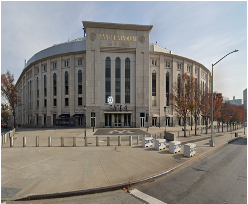 